<div style="background-color: #faf0e6; border: 2px solid #ccc; padding: 8px; text-align: center;">
    <h1 style="color: #696969; margin: 8px 0;">Traffic Signs Machine Learning Report - Research Report Part 2 of 2 </h1>
    <p style="color: #696969; font-size: 20px; margin: 5px 0 0;">
        <span style="display: inline-block; text-align: center; width: 100%;">
            Dataset: 
            <a href="https://www.kaggle.com/datasets/ahemateja19bec1025/traffic-sign-dataset-classification/data?select=labels.csv" style="color: #0066cc; text-decoration: none;">
                https://www.kaggle.com/datasets/ahemateja19bec1025/traffic-sign-dataset-classification/data?select=labels.csv
            </a>
            <br>
            Chris Heimbuch: 
            <a href="https://github.com/chrisheimbuch" style="color: #0066cc; text-decoration: none;">
                https://github.com/chrisheimbuch
            </a>
        </span>
    </p>
</div>

![stopSign.jpg](./images/stopSign.jpg)

## Table of Contents

- [Overview](#Overview)
    - [Section 1: Data Preprocessing](#section-1-data-preprocessing)
    - [Section 2: Classic Machine Learning Approach](#Section-2:-Classic-Machine-Learning-Approach)
    - [Section 3: Histogram of Oriented Gradients](#Section-3:-Histogram-of-Oriented-Gradients)
    - [Section 4: Deep Learning](#Section-4:-Deep-Learning)
    - [Section 5: Test Data Images (Model has Never Seen These)](#Section-5:-Test-Data-Images-(Model-has-Never-Seen-These))
    - [Section 6: Analysis & Conclusion](#Section-6:-Analysis-&-Conclusion)

<div style="background-color: #faf0e6; border: 2px solid #ccc; padding: 20px;">
    <h2 style="color: #696969; margin: 8px 0; text-decoration: underline;"><b>Overview</b></h2>
    <p style="color: black;">In the last notebook, I explored some of the qualities of the dataset. I explored image classes and dimensionality exploration. I observed the height, widths, aspect ratios, and RGB intensity distribution of the image dataset. The majority of images seem to have a height and width of roughly 140 pixels, with many falling outside of that range. Additionally, after observing the RGB intensity of the images, it appears red has the highest intensity among the images. As I delve deeper into the machine learning approach and neural network approach, I expect classic machine learning will not be accurate at identifying the images correctly and will have pretty bad accuracy. Neural networks and deep learning will most likely be employed here to identify meaningful heurstics and patterns within the data.</p>
</div>

In [2]:
import nbformat 

def generate_toc(notebook_path):
    with open(notebook_path) as f:
        nb = nbformat.read(f, as_version=4)

    toc = []
    for cell in nb.cells:
        if cell.cell_type == 'markdown':
            lines = cell.source.split('\n')
            for line in lines:
                if line.startswith('#'):
                    header_level = line.count('#')
                    header_text = line.replace('#', '').strip()
                    toc.append((header_level, header_text))

    toc_md = ['## Table of Contents']
    for level, text in toc:
        toc_md.append(f"{'    ' * (level - 1)}- [{text}](#{text.replace(' ', '-')})")

    return '\n'.join(toc_md)

notebook_path = 'traffic_ml_report.ipynb'
toc_md = generate_toc(notebook_path)

<div style="
    background-color: #faf0e6; 
    border: 2px solid #ccc; 
    padding: 10px; 
    font-family: 'Georgia', serif; 
    font-size: 30px; 
    text-align: left;
    color: #696969;
">
    Section 1: Data Preprocessing
</div>

In [13]:
#Importing in libraries to work with the image data.
import os
import shutil
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image as Image
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

#Classic ML
from skimage.feature import hog
from skimage import color, exposure
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, explained_variance_score, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV

# Machine Learning Algorithms
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score

# TensorFlow and deep learning libraries
import tensorflow as tf
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")


I have 57 different classes which will be tough for the machine learning models to work with. I am going to aggregate the images into three main classes.

In [5]:
#Main directory of my p4 project
main_dir = r"C:\Users\Chris\Documents\Flatiron\Course Materials\Phase_4\P4_Project\source\traffic_Data"

#new variable to combine the directory and combined word
combined = os.path.join(main_dir, "Combined")

#create new folder called "combined" which will combine my 57 classes in the DATA folder.
os.makedirs(combined, exist_ok=True)

In [6]:
#create a new directory for the image classification in newly created combined folder.
output_dir = r"C:\Users\Chris\Documents\Flatiron\Course Materials\Phase_4\P4_Project\source\traffic_Data\Combined"

#new directories
speed_limit_signs = os.path.join(output_dir, 'Speed_Limit')
directional_signs = os.path.join(output_dir, 'Directional_Signs')
warning_signs = os.path.join(output_dir, 'Warning_Signs')

# Create new directories in combined folder, if they don't exist
os.makedirs(speed_limit_signs, exist_ok=True)
os.makedirs(directional_signs, exist_ok=True)
os.makedirs(warning_signs, exist_ok=True)


In [8]:
#load the excel sheet into a DataFrame
path = r'C:\Users\Chris\Documents\Flatiron\Course Materials\Phase_4\P4_Project\source\labels.csv'
df = pd.read_csv(path) 

In [9]:
#Inspect to make sure it loaded correctly
df.head()

,ClassId,Name
0,0,Speed limit (5km/h)
1,1,Speed limit (15km/h)
2,2,Speed limit (30km/h)
3,3,Speed limit (40km/h)
4,4,Speed limit (50km/h)


In [7]:
#Redefining my input directory of training data for the 3 classes we have just created

input_dir_train = r"C:\Users\Chris\Documents\Flatiron\Course Materials\Phase_4\P4_Project\source\traffic_Data\DATA"

Here I will clean up the training data. Currently all images are in 57 different folders for each class.

In [8]:
# Loop through each class
for index, row in df.iterrows():
    class_id = row['ClassId']
    class_name = row['Name'].lower()  

    # Path to the current folder (e.g., 0, 1, etc.)
    class_folder = os.path.join(input_dir_train, str(class_id))

    if not os.path.exists(class_folder):
        print(f"Class folder {class_folder} not found.")
        continue

    # Skip classes with "unknown" in their name
    # if 'unknown' in class_name:
    #     target_folder = directional_signs
    #     # print(f"Skipping class {class_name} (ID: {class_id})")
    #     continue

    # Determine the target folder based on the class name
    if 'speed limit' in class_name:
        target_folder = speed_limit_signs
    elif 'unknown' in class_name:
        target_folder = directional_signs
    elif any(direction in class_name for direction in ['go', 'left', 'right', 'roundabout', 'keep', 'straight', 'curve', 'uturn']):
        target_folder = directional_signs
    elif any(warning in class_name for warning in ['danger', 'crossing', 'construction', 'fences', 'watch', 'stopping', 'entry', 'way', 'accidents', 'traffic', 'horn', 'car', 'divider']):
        target_folder = warning_signs
    else:
        # If the class doesn't match any category, continue
        print(f"Class {class_name} doesn't fit into a known category.")
        continue

    # Move images from the current folder to the target folder
    for image_file in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_file)
        if os.path.isfile(image_path):
            shutil.move(image_path, os.path.join(target_folder, image_file))

    print(f"Moved images from class {class_name} (ID: {class_id}) to {target_folder}")


Moved images from class speed limit (5km/h) (ID: 0) to C:\Users\Chris\Documents\Flatiron\Course Materials\Phase_4\P4_Project\traffic_Data\Combined\Speed_Limit
Moved images from class speed limit (15km/h) (ID: 1) to C:\Users\Chris\Documents\Flatiron\Course Materials\Phase_4\P4_Project\traffic_Data\Combined\Speed_Limit
Moved images from class speed limit (30km/h) (ID: 2) to C:\Users\Chris\Documents\Flatiron\Course Materials\Phase_4\P4_Project\traffic_Data\Combined\Speed_Limit
Moved images from class speed limit (40km/h) (ID: 3) to C:\Users\Chris\Documents\Flatiron\Course Materials\Phase_4\P4_Project\traffic_Data\Combined\Speed_Limit
Moved images from class speed limit (50km/h) (ID: 4) to C:\Users\Chris\Documents\Flatiron\Course Materials\Phase_4\P4_Project\traffic_Data\Combined\Speed_Limit
Moved images from class speed limit (60km/h) (ID: 5) to C:\Users\Chris\Documents\Flatiron\Course Materials\Phase_4\P4_Project\traffic_Data\Combined\Speed_Limit
Moved images from class speed limit (70km

After running this code, instead of having 57 different classes (or folders), now we have an organized structure of 3 classes, more balanced than before, with a better understanding of the sign classification (directional signs, speed limit signs, and warning signs!)

The Test images have a naming convention of 000, 001, 002 to signify which class it belongs to. However, to accurately test the models on these, we need to aggregate them into similar folders, exactly like the training data so we can test if our models are accurate or not!

In [10]:
#Going to prepare image data to work with. I will first handle the training data.

#Setting variable to directory for my TEST images.
input_dir_test = r"C:\Users\Chris\Documents\Flatiron\Course Materials\Phase_4\P4_Project\source\traffic_Data\TEST"

In [11]:
#new directories
speed_limit_signs = os.path.join(input_dir_test, 'Speed_Limit')
directional_signs = os.path.join(input_dir_test, 'Directional_Signs')
warning_signs = os.path.join(input_dir_test, 'Warning_Signs')

#Create new directories in combined folder, if they don't exist
os.makedirs(speed_limit_signs, exist_ok=True)
os.makedirs(directional_signs, exist_ok=True)
os.makedirs(warning_signs, exist_ok=True)

In [12]:
#mapping for TEST images.
sign_map = df.set_index('ClassId')['Name'].to_dict()


In [45]:
#Iterate through each file in the test directory
for file_name in os.listdir(input_dir_test):

        #Extract the class ID from the file name (the naming convention for these images have the first three characters corresponding to the class they belong to)
        class_id = file_name[:3]

        #this will get the class from the dictionary and convert the first part of the 
        class_name = sign_map.get(int(class_id))  

        #determine which folder the test image belongs to based on classification, using same sorting from training images.
        if 'speed limit' in class_name.lower():
            target_folder = speed_limit_signs
        elif 'unknown' in class_name.lower():
            target_folder = directional_signs
        elif any(direction in class_name.lower() for direction in ['go', 'left', 'right', 'roundabout', 'keep', 'straight', 'curve', 'uturn']):
            target_folder = directional_signs
        elif any(warning in class_name.lower() for warning in ['danger', 'crossing', 'construction', 'fences', 'watch', 'stopping', 'entry', 'way', 'accidents', 'traffic', 'horn', 'car', 'divider']):
            target_folder = warning_signs
        else:
            continue  

        #move images
        src_path = os.path.join(input_dir_test, file_name)
        dest_path = os.path.join(target_folder, file_name)
        shutil.move(src_path, dest_path)

print("Test images sorted successfully!")

Test images sorted successfully!


<div style="
    background-color: #faf0e6; 
    border: 2px solid #ccc; 
    padding: 10px; 
    font-family: 'Georgia', serif; 
    font-size: 30px; 
    text-align: left;
    color: #696969;
">
    Section 2: Classic Machine Learning Approach
</div>

In [14]:
#Redefining my input directory of training data for the 3 classes we have just created

input_dir_train = r"C:\Users\Chris\Documents\Flatiron\Course Materials\Phase_4\P4_Project\traffic_Data\Combined"

In [15]:
#Here I am extracting out the images from my combined folder, and adding them to the "image" variable. 
#By default, cv2 stores image in BGR format, in which to display some images, I will need to convert them to RGB.

image_list = os.listdir(input_dir_train)
folders = ['Directional_Signs', 'Speed_Limit', 'Warning_Signs']

image = []
class_name = []

for folder_name in folders:
    folder_path = os.path.join(input_dir_train, folder_name)

    #list of images in newly created folders
    pictures = os.listdir(folder_path)

    for img in pictures:
        img_path = os.path.join(folder_path, img)
        current = cv2.imread(img_path)
        #Convert to RGB for plotting for matplotlib
        current_rgb = cv2.cvtColor(current, cv2.COLOR_BGR2RGB)

        image.append(current_rgb)
        class_name.append(folder_name)

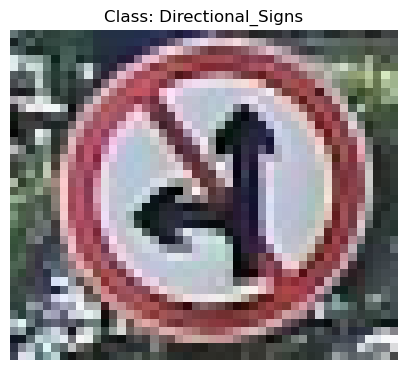

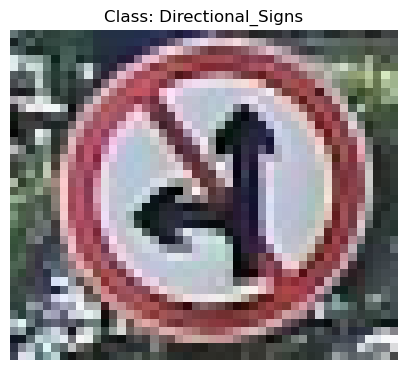

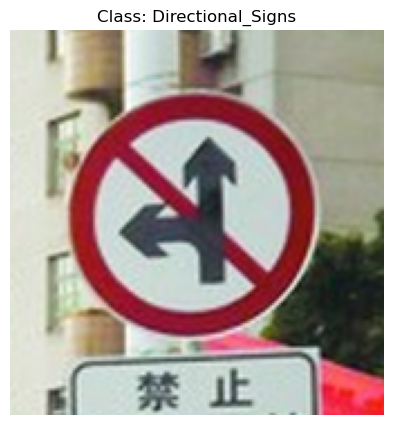

In [16]:
#Inspect a few images in the image list

# Display one image from each folder
for i in range(3): 
    plt.figure(figsize=(5, 5))
    plt.imshow(image[i])
    plt.title(f"Class: {class_name[i]}")
    plt.axis('off')
    plt.show()

In [17]:
#Going to prepare image data to work with. I will first handle the training data.

image_data = []
labels = []
folders = ['Directional_Signs', 'Speed_Limit', 'Warning_Signs']

# Create a mapping from folder names to numeric labels
label_mapping = {'Directional_Signs': 0, 'Speed_Limit': 1, 'Warning_Signs': 2}

#Create a loop to go through each class folder
for folder_name in folders:
    folder_path = os.path.join(input_dir_train, folder_name)

    #Check to see if the folder is an actual directory.
    if os.path.isdir(folder_path):
        #here we will loop through each image in the given class folder (directional, speed limit, or warning signs)
        for image in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image)

            #read the image in color.
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)

            #this will only proceed if the image exists
            if img is not None:
                #resize image to fixed size so its uniform ( as most images had different heights and widths)
                img_resized = cv2.resize(img, (32,32))

                #make image interpretable for machine models by flattening it into a 1D array.
                img_flattened = img_resized.flatten()

                #add the flattened image and the label to the lists above that we instantiated.
                image_data.append(img_flattened)
                labels.append(label_mapping[folder_name])
            else:
                print(f"The image could not be read {image_path}")

#convert the lists into numpy arrays for efficiency
image_data = np.array(image_data)
labels = np.array(labels)


In [18]:
#Convert image data to a DataFrame
df = pd.DataFrame(image_data)

#Scale data so it is more managable for machine models.
df = df / 255

# Add the labels as the target column
df['label'] = labels

df

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,label
0,0.392157,0.392157,0.329412,0.254902,0.266667,0.196078,0.298039,0.317647,0.247059,0.231373,...,0.462745,0.447059,0.415686,0.588235,0.580392,0.556863,0.431373,0.427451,0.423529,0
1,0.392157,0.392157,0.329412,0.254902,0.266667,0.196078,0.298039,0.317647,0.247059,0.231373,...,0.462745,0.447059,0.415686,0.588235,0.580392,0.556863,0.431373,0.427451,0.423529,0
2,0.843137,0.874510,0.870588,0.811765,0.878431,0.858824,0.843137,0.886275,0.878431,0.368627,...,0.286275,0.149020,0.941176,0.207843,0.172549,0.945098,0.094118,0.125490,0.956863,0
3,0.890196,0.913725,0.949020,0.909804,0.917647,0.964706,0.933333,0.933333,0.980392,0.898039,...,0.800000,0.796078,0.800000,0.831373,0.839216,0.866667,0.788235,0.807843,0.854902,0
4,0.392157,0.392157,0.329412,0.254902,0.266667,0.196078,0.298039,0.317647,0.247059,0.231373,...,0.462745,0.447059,0.415686,0.588235,0.580392,0.556863,0.431373,0.427451,0.423529,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4165,0.188235,0.247059,0.254902,0.686275,0.764706,0.858824,0.545098,0.643137,0.733333,0.337255,...,0.262745,0.458824,0.419608,0.227451,0.439216,0.388235,0.219608,0.427451,0.360784,2
4166,0.823529,0.788235,0.752941,0.533333,0.517647,0.494118,0.254902,0.266667,0.219608,0.670588,...,0.337255,0.541176,0.501961,0.290196,0.474510,0.435294,0.329412,0.525490,0.490196,2
4167,0.592157,0.623529,0.486275,0.603922,0.619608,0.490196,0.584314,0.611765,0.454902,0.615686,...,0.474510,0.462745,0.423529,0.454902,0.470588,0.470588,0.192157,0.196078,0.180392,2
4168,0.254902,0.313725,0.333333,0.552941,0.552941,0.505882,0.549020,0.537255,0.494118,0.600000,...,0.184314,0.184314,0.184314,0.254902,0.282353,0.254902,0.262745,0.274510,0.239216,2


Now that we have our class data organized into a dataframe with RGB values per image (images were converted to 32x32=1024, 1024x3=3072 features to represent RGB values, and 4072 total images), lets split out data up into training and test splits to try a shotgun approach, where we will have classic machine learning models predict on images and testing data.

In [19]:
#Going to create a function for "Shotgun approach" for machine learning modeling.

def classification_model_test(model, X_train, y_train, X_test, y_test):
    # Fit the model with the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate and return the accuracy score
    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

    # Generate heatmap of confusion matrix
    sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred),
            annot=True,
            cmap="coolwarm",
            square=True)

    # Print classification report
    print(classification_report(y_true=y_test, y_pred=y_pred))

    return f"Accuracy Score: {accuracy:.2f}"

In [20]:
X = df.drop(columns=['label'])
y = df['label']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       304
           1       0.99      0.99      0.99       206
           2       0.98      0.97      0.98       324

    accuracy                           0.98       834
   macro avg       0.98      0.98      0.98       834
weighted avg       0.98      0.98      0.98       834



'Accuracy Score: 0.98'

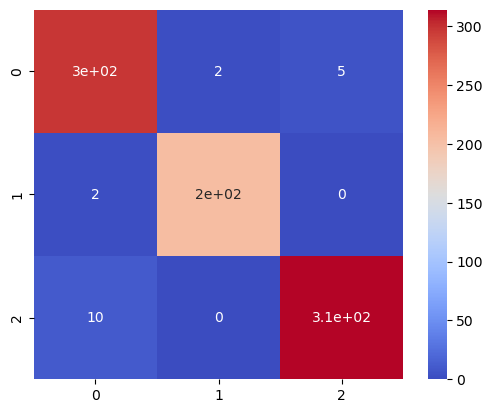

In [21]:
log_reg = LogisticRegression()
classification_model_test(log_reg, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.69      0.67      0.68       304
           1       0.92      0.86      0.89       206
           2       0.75      0.80      0.77       324

    accuracy                           0.77       834
   macro avg       0.78      0.78      0.78       834
weighted avg       0.77      0.77      0.77       834



'Accuracy Score: 0.77'

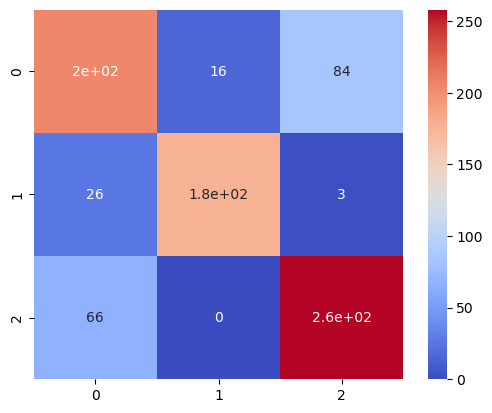

In [22]:
ada_model = AdaBoostClassifier()
classification_model_test(ada_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       304
           1       1.00      0.97      0.98       206
           2       0.95      0.95      0.95       324

    accuracy                           0.96       834
   macro avg       0.96      0.96      0.96       834
weighted avg       0.96      0.96      0.96       834



'Accuracy Score: 0.96'

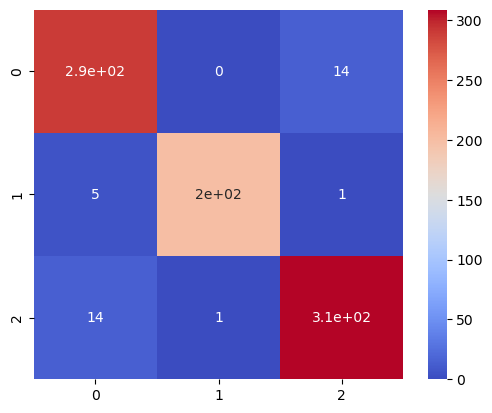

In [23]:
svc_model = SVC()
classification_model_test(svc_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       304
           1       0.99      1.00      1.00       206
           2       0.99      0.98      0.99       324

    accuracy                           0.99       834
   macro avg       0.99      0.99      0.99       834
weighted avg       0.99      0.99      0.99       834



'Accuracy Score: 0.99'

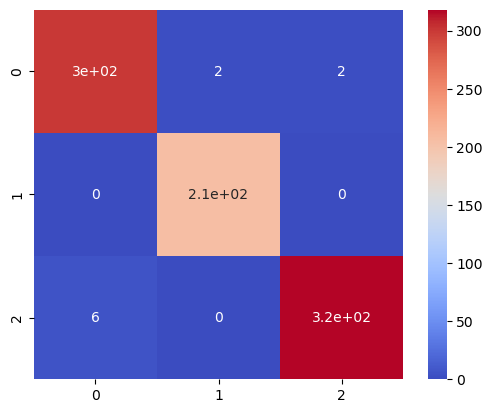

In [24]:
gbc_model = GradientBoostingClassifier()
classification_model_test(gbc_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       304
           1       0.98      0.99      0.99       206
           2       1.00      0.89      0.94       324

    accuracy                           0.95       834
   macro avg       0.96      0.95      0.95       834
weighted avg       0.95      0.95      0.95       834



'Accuracy Score: 0.95'

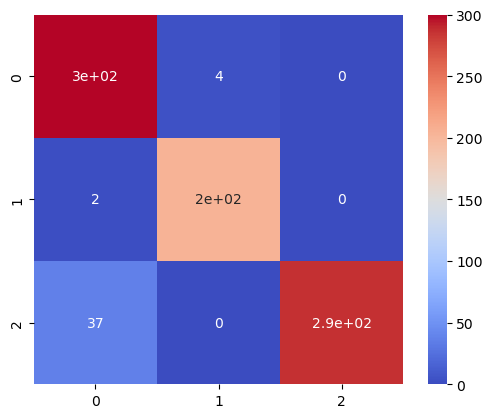

In [25]:
sgd_model = SGDClassifier()
classification_model_test(sgd_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       304
           1       1.00      1.00      1.00       206
           2       0.99      0.98      0.98       324

    accuracy                           0.99       834
   macro avg       0.99      0.99      0.99       834
weighted avg       0.99      0.99      0.99       834



'Accuracy Score: 0.99'

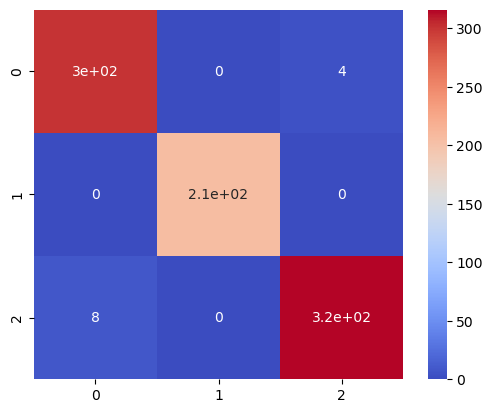

In [26]:
rfc_model = RandomForestClassifier()
classification_model_test(rfc_model, X_train, y_train, X_test, y_test)

My classic ML approach actually worked better than I had expected after normalizing and preprocessing my image data. Prior to aggregating the images into 3 classes, it had some trouble identifying 57 classes. This has helped and proved to be much better. I may run a random search classifier to try and improve the model accuracy for SGD and SVC models.

In [37]:
#Setup cross-validation for hyper parameter tuning and grids for hyperparameter tuning for the models I will be focusing on.

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

#Create grid search for SGD and .

grid_sgd = {
    "penalty": ["l2", "l1", "elasticnet"],
    "alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    "max_iter": [100, 200, 300, 400, 500],
    "learning_rate": ["constant", "optimal", "invscaling", "adaptive"],
    "eta0": [0.01, 0.1, 1],
    "class_weight": [None, 'balanced'],
    'average': [False, True]
}

grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'sigmoid'],
    'degree': [2, 3, 4],
    'coef0': [0, 0.1, 1],
    'tol': [1e-3, 1e-4],
    'max_iter': [10, 20, 30],
    'class_weight': [None, 'balanced']
}

grid_gbc = {
    'n_estimators': [5, 10, 15],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2]
}

In [31]:
search = RandomizedSearchCV(
    estimator=sgd_model,
    param_distributions=grid_sgd,  
    n_iter=10,  
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42 
)

In [32]:
#Create result variable to fit the search gridsearch with x train and y train data.
result = search.fit(X_train, y_train)

In [33]:
#Print best score and optimal parameters.
print("> BEST SCORE: \t\t{}".format(result.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result.best_params_))

> BEST SCORE: 		0.9616331900763038
> OPTIMAL PARAMETERS: 	{'penalty': 'l1', 'max_iter': 100, 'learning_rate': 'adaptive', 'eta0': 0.1, 'class_weight': None, 'average': True, 'alpha': 1e-07}


In [46]:
search_svc = RandomizedSearchCV(
    estimator=svc_model,
    param_distributions=grid_svc,  
    n_iter=10,  
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42)

In [47]:
#Create result variable to fit the search gridsearch with x train and y train data.
result_svc = search_svc.fit(X_train, y_train)

In [48]:
#Print best score and optimal parameters.
print("> BEST SCORE: \t\t{}".format(result_svc.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result_svc.best_params_))

> BEST SCORE: 		0.6026259792726859
> OPTIMAL PARAMETERS: 	{'tol': 0.0001, 'max_iter': 30, 'kernel': 'poly', 'degree': 2, 'coef0': 1, 'class_weight': None, 'C': 10}


Interestingly enough, the stochastic gradient descent model performed very well with tuning, and the support vector machine model performed worse with hyper parameter tuning. So for a classic machine learning approach, it appears that the SGD model is the best one!

Next, lets look into histogram of oriented gradients (or HOG) to see if we get any improvements, before we dive into deep learning.

<div style="
    background-color: #faf0e6; 
    border: 2px solid #ccc; 
    padding: 10px; 
    font-family: 'Georgia', serif; 
    font-size: 30px; 
    text-align: left;
    color: #696969;
">
    Section 3: Histogram of Oriented Gradients Approach
</div>

One method that one can use when working with image data is called the HOG (Histogram of Oriented Gradients) which is a feature descriptor used in computer vision and image processing for object detection. It works using Gradient computation among many things, to uncover edge and shape detection among complex images.

I will first use some code to display a before and after image of each class, in black and white, and after HOG has been applied. We can get an idea of what this does and then I will apply it to all my images.

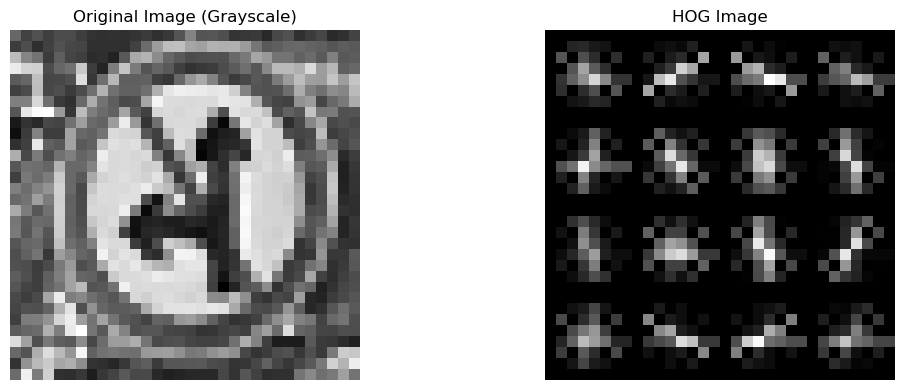

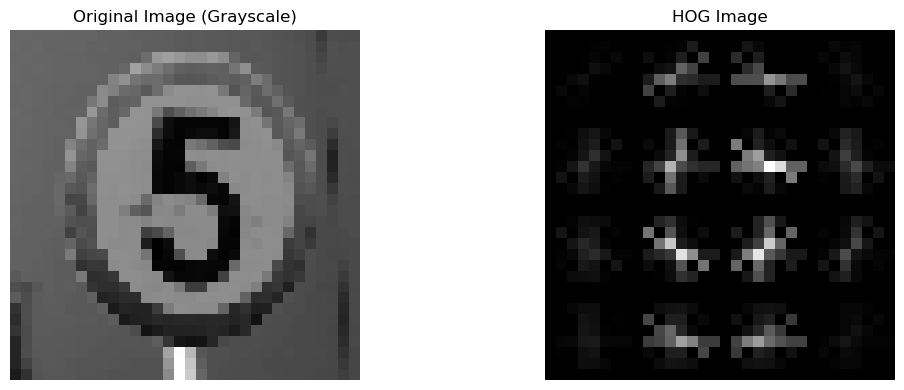

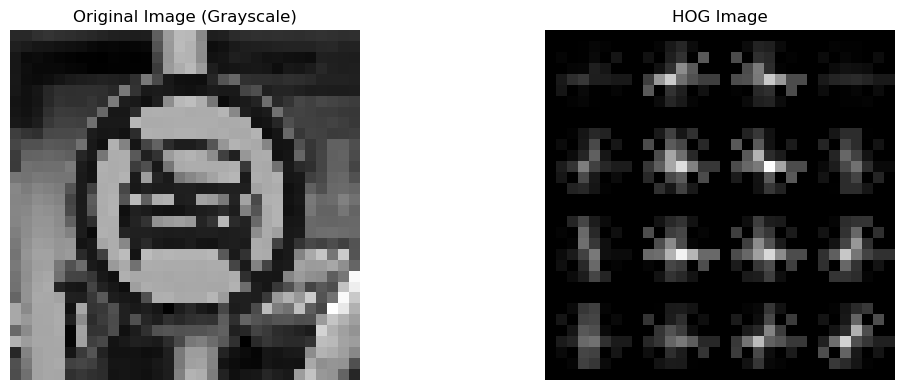

In [27]:
#Loop through each folder 
for folder_name in folders:
    folder_path = os.path.join(input_dir_train, folder_name)

    #Check if the folder is an actual directory
    if os.path.isdir(folder_path):
        #Loop through each image in the class folder
        for image in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image)

            #Read the image in color
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)

            #This will only proceed if the image exists
            if img is not None:
                # Resize image to fixed size so it's uniform
                img_resized = cv2.resize(img, (32,32))

                #Convert image to grayscale
                img_gray = color.rgb2gray(img_resized)

                # Display original image (grayscale)
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(img_gray, cmap='gray')
                plt.title('Original Image (Grayscale)')
                plt.axis('off')

                #Apply HOG descriptor
                hog_features, hog_image = hog(img_gray,
                                              orientations=9,
                                              pixels_per_cell=(8, 8),
                                              cells_per_block=(2, 2),
                                              block_norm='L2-Hys',
                                              visualize=True)

                # Display HOG image
                plt.subplot(1, 2, 2)
                plt.imshow(hog_image, cmap='gray')
                plt.title('HOG Image')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

                break  

In [53]:
#this will hold the class and image data once HOG is applied
image_data_hog = []
labels = []

#Loop through each folder 
for folder_name in folders:
    folder_path = os.path.join(input_dir_train, folder_name)

    #Check if the folder is an actual directory
    if os.path.isdir(folder_path):
        #Loop through each image in the class folder
        for image in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image)

            #Read the image in color
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)

            #This will only proceed if the image exists
            if img is not None:
                

                #resize image to fixed size so its uniform ( as most images had different heights and widths)
                img_resized = cv2.resize(img, (32,32))

                #convert image to grayscale
                img_gray = color.rgb2gray(img_resized)

                #apply HOG descriptor
                hog_features, hog_image = hog(img_gray,
                                              orientations=9,
                                              pixels_per_cell=(8, 8),
                                              cells_per_block=(2, 2),
                                              block_norm='L2-Hys',
                                              visualize=True)

                 #flatten the HOG features into 1D array for machine learning models
                hog_features_flattened = hog_features.flatten()                

                #Add HOG features to the list
                image_data_hog.append(hog_features_flattened)

                #Assign labels based on the folder (0, 1, or 2)
                if folder_name == 'Directional_Signs':
                    labels.append(0)
                elif folder_name == 'Speed_Limit':
                    labels.append(1)
                elif folder_name == 'Warning_Signs':
                    labels.append(2)
            else:
                print(f"Image could not be read: {image_path}")

# Convert lists to numpy arrays
image_data_hog = np.array(image_data_hog)
labels = np.array(labels)

print("Finished getting HOG features")

Finished getting HOG features


In [71]:
#Convert image data to a DataFrame
df_hog = pd.DataFrame(image_data_hog)

#Scale data so it is more managable for machine models.
# df = df / 255

# Add the labels as the target column
df_hog['label'] = labels

df

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,label
0,0.392157,0.392157,0.329412,0.254902,0.266667,0.196078,0.298039,0.317647,0.247059,0.231373,...,0.462745,0.447059,0.415686,0.588235,0.580392,0.556863,0.431373,0.427451,0.423529,0
1,0.392157,0.392157,0.329412,0.254902,0.266667,0.196078,0.298039,0.317647,0.247059,0.231373,...,0.462745,0.447059,0.415686,0.588235,0.580392,0.556863,0.431373,0.427451,0.423529,0
2,0.843137,0.874510,0.870588,0.811765,0.878431,0.858824,0.843137,0.886275,0.878431,0.368627,...,0.286275,0.149020,0.941176,0.207843,0.172549,0.945098,0.094118,0.125490,0.956863,0
3,0.890196,0.913725,0.949020,0.909804,0.917647,0.964706,0.933333,0.933333,0.980392,0.898039,...,0.800000,0.796078,0.800000,0.831373,0.839216,0.866667,0.788235,0.807843,0.854902,0
4,0.392157,0.392157,0.329412,0.254902,0.266667,0.196078,0.298039,0.317647,0.247059,0.231373,...,0.462745,0.447059,0.415686,0.588235,0.580392,0.556863,0.431373,0.427451,0.423529,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4165,0.188235,0.247059,0.254902,0.686275,0.764706,0.858824,0.545098,0.643137,0.733333,0.337255,...,0.262745,0.458824,0.419608,0.227451,0.439216,0.388235,0.219608,0.427451,0.360784,2
4166,0.823529,0.788235,0.752941,0.533333,0.517647,0.494118,0.254902,0.266667,0.219608,0.670588,...,0.337255,0.541176,0.501961,0.290196,0.474510,0.435294,0.329412,0.525490,0.490196,2
4167,0.592157,0.623529,0.486275,0.603922,0.619608,0.490196,0.584314,0.611765,0.454902,0.615686,...,0.474510,0.462745,0.423529,0.454902,0.470588,0.470588,0.192157,0.196078,0.180392,2
4168,0.254902,0.313725,0.333333,0.552941,0.552941,0.505882,0.549020,0.537255,0.494118,0.600000,...,0.184314,0.184314,0.184314,0.254902,0.282353,0.254902,0.262745,0.274510,0.239216,2


In [72]:
X_hog = df_hog.drop(columns=['label'])
y_hog = df_hog['label']

# Split the data into training and test sets
X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(X_hog, y_hog, train_size=0.8, test_size=0.2, random_state=42)

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       304
           1       0.93      0.96      0.95       206
           2       0.88      0.93      0.91       324

    accuracy                           0.90       834
   macro avg       0.91      0.91      0.91       834
weighted avg       0.90      0.90      0.90       834



'Accuracy Score: 0.90'

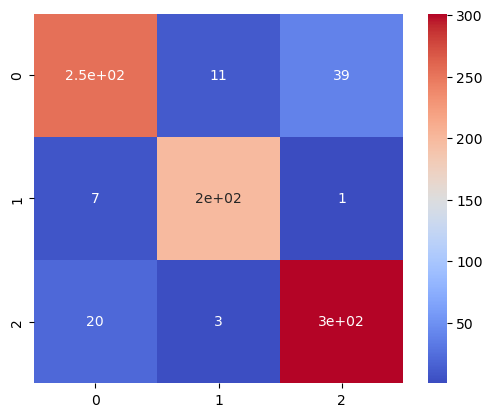

In [73]:
log_reg_hog = LogisticRegression()
classification_model_test(log_reg_hog, X_train_hog, y_train_hog, X_test_hog, y_test_hog)

              precision    recall  f1-score   support

           0       0.72      0.62      0.66       304
           1       0.86      0.89      0.87       206
           2       0.76      0.84      0.80       324

    accuracy                           0.77       834
   macro avg       0.78      0.78      0.78       834
weighted avg       0.77      0.77      0.77       834



'Accuracy Score: 0.77'

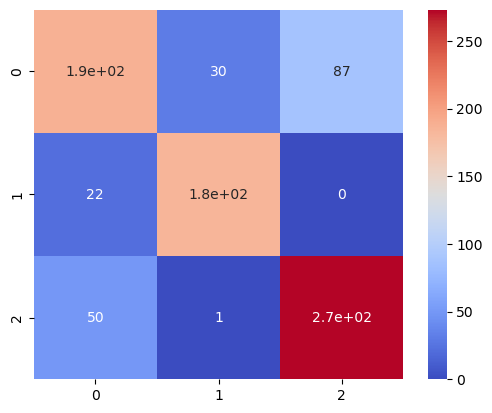

In [75]:
ada_model_hog = AdaBoostClassifier()
classification_model_test(ada_model_hog, X_train_hog, y_train_hog, X_test_hog, y_test_hog)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       304
           1       0.98      1.00      0.99       206
           2       0.98      0.98      0.98       324

    accuracy                           0.98       834
   macro avg       0.98      0.98      0.98       834
weighted avg       0.98      0.98      0.98       834



'Accuracy Score: 0.98'

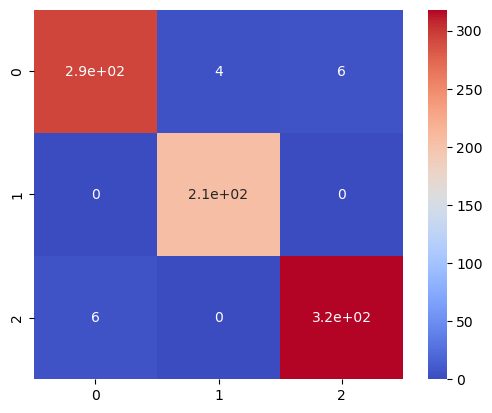

In [76]:
svc_model_hog = SVC()
classification_model_test(svc_model_hog, X_train_hog, y_train_hog, X_test_hog, y_test_hog)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       304
           1       0.99      1.00      1.00       206
           2       0.98      1.00      0.99       324

    accuracy                           0.99       834
   macro avg       0.99      0.99      0.99       834
weighted avg       0.99      0.99      0.99       834



'Accuracy Score: 0.99'

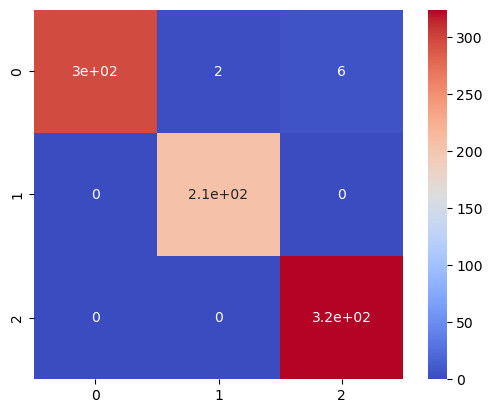

In [77]:
gbc_model_hog = GradientBoostingClassifier()
classification_model_test(gbc_model_hog, X_train_hog, y_train_hog, X_test_hog, y_test_hog)

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       304
           1       0.97      0.92      0.94       206
           2       0.88      0.94      0.91       324

    accuracy                           0.91       834
   macro avg       0.92      0.91      0.91       834
weighted avg       0.91      0.91      0.91       834



'Accuracy Score: 0.91'

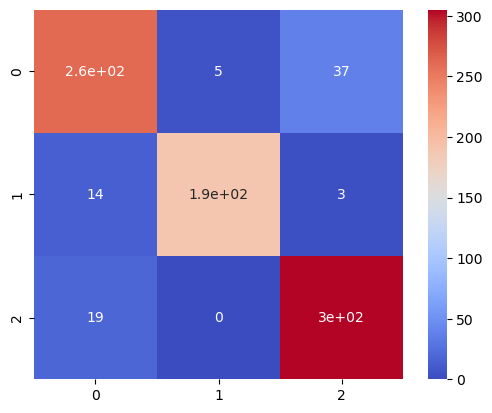

In [78]:
sgd_model_hog = SGDClassifier()
classification_model_test(sgd_model_hog, X_train_hog, y_train_hog, X_test_hog, y_test_hog)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       304
           1       0.99      1.00      1.00       206
           2       0.99      1.00      1.00       324

    accuracy                           1.00       834
   macro avg       0.99      1.00      1.00       834
weighted avg       1.00      1.00      1.00       834



'Accuracy Score: 1.00'

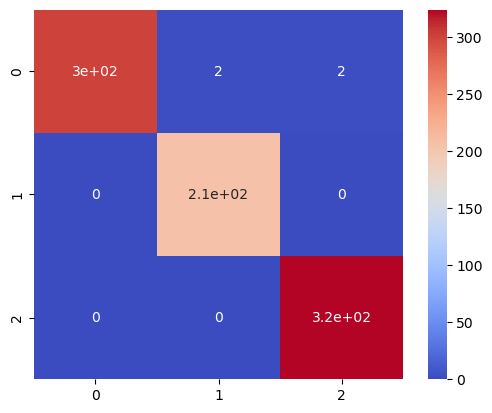

In [79]:
rfc_model_hog = RandomForestClassifier()
classification_model_test(rfc_model_hog, X_train_hog, y_train_hog, X_test_hog, y_test_hog)

<div style="
    background-color: #faf0e6; 
    border: 2px solid #ccc; 
    padding: 10px; 
    font-family: 'Georgia', serif; 
    font-size: 30px; 
    text-align: left;
    color: #696969;
">
    Section 4: Deep Learning
</div>

The basic ML models seemed to have predicted classes very well. I will construct a CNN (Convolutional Neural Network) and train it to also learn on the image data!

Before I get started with training the network, I will set up a frame work. The machine learning models took in data as a 1D array. For a Convolutional Neural Network to work, it looks at height and width of images (2D). Therefore, I will need to preprocess my data before sending the image data to the network.

In [21]:
#This will be a sequential CNN network

#Instance a sequential layer architecture
Sequential = tf.keras.models.Sequential

#CNN network layers
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout
Flatten = tf.keras.layers.Flatten
Conv2D = tf.keras.layers.Conv2D
MaxPool2D = tf.keras.layers.MaxPool2D

#Optimizer
Adam = tf.keras.optimizers.Adam

#Image preprocessing for better learning
ImageDataGenerator =  tf.keras.preprocessing.image.ImageDataGenerator


Like before, I need to access my directories and the images within them. I then need to do some preprocessing, like reshaping and scaling. I will do that now.

In [22]:
cnn_image_data = []
cnn_labels = []
folders = ['Directional_Signs', 'Speed_Limit', 'Warning_Signs']

# reate a mapping from folder names to numeric labels
label_mapping = {'Directional_Signs': 0, 'Speed_Limit': 1, 'Warning_Signs': 2}

#Loop to go through each class folder
for folder_name in folders:
    folder_path = os.path.join(input_dir_train, folder_name)

    #Check if the folder is an actual directory
    if os.path.isdir(folder_path):
        #Loop through each image in the given class folder
        for image in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image)

            #Read the image in color (height, width, channels)
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)

            #This will only proceed if the image exists
            if img is not None:
                #Resize image to fixed size (32x32x3) for CNN input
                img_resized = cv2.resize(img, (32, 32))

                #Add the resized image and the label to the lists above
                cnn_image_data.append(img_resized)
                cnn_labels.append(label_mapping[folder_name])
            else:
                print(f"The image could not be read: {image_path}")

#Convert the lists into numpy arrays for efficiency
cnn_image_data = np.array(cnn_image_data)  # This will have shape (num_images, 32, 32, 3)
cnn_labels = np.array(cnn_labels)


In [23]:
#I am going to scale the image data to 0-1 range for the model.

cnn_image_data = cnn_image_data / 255.0  

cnn_image_data

array([[[[0.39215686, 0.39215686, 0.32941176],
         [0.25490196, 0.26666667, 0.19607843],
         [0.29803922, 0.31764706, 0.24705882],
         ...,
         [0.17254902, 0.18039216, 0.16470588],
         [0.19607843, 0.20392157, 0.19215686],
         [0.2627451 , 0.2627451 , 0.25098039]],

        [[0.24313725, 0.24705882, 0.18823529],
         [0.29019608, 0.30588235, 0.23137255],
         [0.17647059, 0.20392157, 0.13333333],
         ...,
         [0.29411765, 0.33333333, 0.30588235],
         [0.32941176, 0.36078431, 0.3372549 ],
         [0.3254902 , 0.34509804, 0.32156863]],

        [[0.68235294, 0.68235294, 0.61960784],
         [0.48627451, 0.49803922, 0.42745098],
         [0.41568627, 0.43921569, 0.36470588],
         ...,
         [0.41960784, 0.49019608, 0.45490196],
         [0.29019608, 0.34901961, 0.31372549],
         [0.31764706, 0.36078431, 0.32941176]],

        ...,

        [[0.41960784, 0.38431373, 0.34117647],
         [0.34117647, 0.32156863, 0.2627451 ]

In [24]:
# # Split the data into training and test sets
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(cnn_image_data, cnn_labels, train_size=0.8, test_size=0.2, random_state=42)

# Image Type Forcing
X_train_cnn = X_train_cnn.astype("float32"); X_test_cnn = X_test_cnn.astype("float32")

In [25]:
#One-hot encode the labels
y_train_cnn = to_categorical(y_train_cnn, num_classes=3)
y_test_cnn = to_categorical(y_test_cnn, num_classes=3)

Great! Our data now looks ready for our CNN network. Let's get the architecture set up.

In [26]:
# Here I will define the network layers.
convolutional_layer_1 = Conv2D(50,
                               kernel_size=(3, 3),
                               strides=(1, 1),
                               padding="same",
                               activation="relu",
                               input_shape=(32, 32, 3))
convolutional_layer_2 = Conv2D(75,
                               kernel_size=(3, 3),
                               strides=(1, 1),
                               padding="same",
                               activation="relu")
convolutional_layer_3 = Conv2D(125,
                               kernel_size=(3, 3),
                               strides=(1, 1),
                               padding="same",
                               activation="relu")

# Two corresponding pooling layers to reduce convolved dimensionality
pooling_layer_1 =         MaxPool2D(pool_size=(2, 2))
pooling_layer_2 =         MaxPool2D(pool_size=(2, 2))

# Four dropout layers: two for the convolutions and two for the ANN
dropout_layer_1 =         Dropout(0.25)
dropout_layer_2 =         Dropout(0.25)
dropout_layer_3 =         Dropout(0.4)
dropout_layer_4 =         Dropout(0.3)

# A flattening layer for ingestion into the ANN
flattening_layer_1 =      Flatten()

# Three dense layers to make up the significant ANN architecture
connective_layer_1 =      Dense(500, activation="relu")
connective_layer_2 =      Dense(250, activation="relu")
output_layer =            Dense(3, activation="softmax")


In [27]:
# Initialize sequential model schema
model = Sequential()

# Add first convolutional feature mapping process layers
model.add(convolutional_layer_1)

# Add second convolutional feature mapping process layers
model.add(convolutional_layer_2)
model.add(pooling_layer_1)
model.add(dropout_layer_1)

# Add third convolutional feature mapping process layers
model.add(convolutional_layer_3)
model.add(pooling_layer_2)
model.add(dropout_layer_2)

# Add image vectorization process layer
model.add(flattening_layer_1)

# Add connective ANN process layers
model.add(connective_layer_1)
model.add(dropout_layer_3)
model.add(connective_layer_2)
model.add(dropout_layer_4)
model.add(output_layer)

# Summarize model layering setup
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 50)        1400      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 75)        33825     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 75)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 75)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 125)       84500     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 125)        0         
 2D)                                                    

In [28]:
# Define Adam optimization
optimizer = Adam(learning_rate=0.001)

In [29]:
# Set compilation properties
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Set epochs and batch size
epochs, batch_size = 40, 32

In [30]:
# Create image augmentation engine as generator-like object
generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
)

# Fit training data to augmentation generator
generator.fit(X_train_cnn)

In [62]:
#created this only if necessary to use. Doesn't seem like I will need this.

#Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,          #this is the number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Rstores the model weights from the best epoch with the lowest validation loss
)

#Define ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint(
    filepath='best_model_traffic_images.h5',  #path where model is saved
    monitor='val_loss',        
    save_best_only=True,       
    verbose=1                  
)

In [32]:
print("Independent training set size:\t\t{}".format(X_train_cnn.shape))
print("Independent validation set size:\t{}".format(X_test_cnn.shape))
print("Target training set size:\t\t{}".format(y_train_cnn.shape))
print("Target validation set size:\t\t{}".format(y_test_cnn.shape))

Independent training set size:		(3336, 32, 32, 3)
Independent validation set size:	(834, 32, 32, 3)
Target training set size:		(3336, 3)
Target validation set size:		(834, 3)


In [33]:
# Fit model using generator-augmented dataset and mini-batch ingestion
history = model.fit(
    generator.flow(X_train_cnn,
                   y_train_cnn,
                   batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_test_cnn, y_test_cnn),
    batch_size=batch_size,
    #callbacks=[early_stopping, model_checkpoint] #This is only if the model is not learning and if something crashes, there will be a save state of performance.
)

Epoch 1/40
105/105 [==============================] - 11s 46ms/step - loss: 0.9802 - accuracy: 0.4814 - val_loss: 0.8319 - val_accuracy: 0.5839
Epoch 2/40
105/105 [==============================] - 55s 532ms/step - loss: 0.6232 - accuracy: 0.7071 - val_loss: 0.4348 - val_accuracy: 0.7962
Epoch 3/40
105/105 [==============================] - 200s 2s/step - loss: 0.4062 - accuracy: 0.8150 - val_loss: 0.2703 - val_accuracy: 0.8897
Epoch 4/40
105/105 [==============================] - 176s 2s/step - loss: 0.2850 - accuracy: 0.8792 - val_loss: 0.1669 - val_accuracy: 0.9257
Epoch 5/40
105/105 [==============================] - 84s 809ms/step - loss: 0.2234 - accuracy: 0.9062 - val_loss: 0.1576 - val_accuracy: 0.9329
Epoch 6/40
105/105 [==============================] - 125s 1s/step - loss: 0.1850 - accuracy: 0.9260 - val_loss: 0.1011 - val_accuracy: 0.9556
Epoch 7/40
105/105 [==============================] - 196s 2s/step - loss: 0.1646 - accuracy: 0.9362 - val_loss: 0.1448 - val_accuracy: 0

In [34]:
#Let's visualize the results
def plot_training_results(history):
    """
    Visualize results of the model training using `matplotlib`.

    The visualization will include charts for accuracy and loss,
    on the training and as well as validation data sets.

    INPUTS:
        history(tf.keras.callbacks.History):
            Contains data on how the model metrics changed
            over the course of training.

    OUTPUTS:
        None.
    """
    # Get accuracy for training and validation sets
    accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    # Get loss for training and validation sets
    loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Get range of epochs to produce common plotting range
    epochs_range = range(epochs)

    # Instantiate plotting figure space
    plt.figure(figsize=(20, 8))

    # Create training/validation accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Create training/validation loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    # Render visualization
    plt.show()

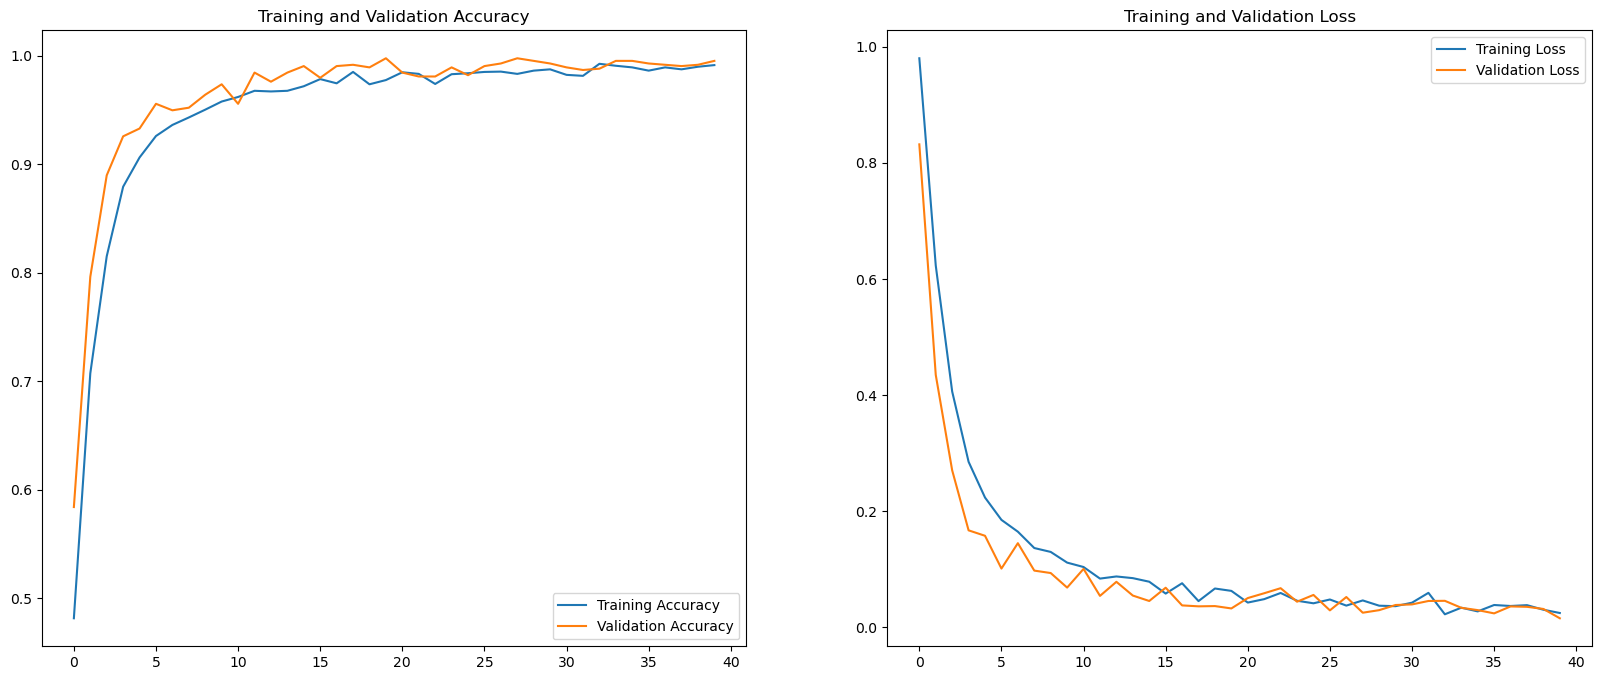

In [35]:
# Visualize accuracy and loss for training and validation datasets
plot_training_results(history)

27/27 [==============================] - 9s 321ms/step


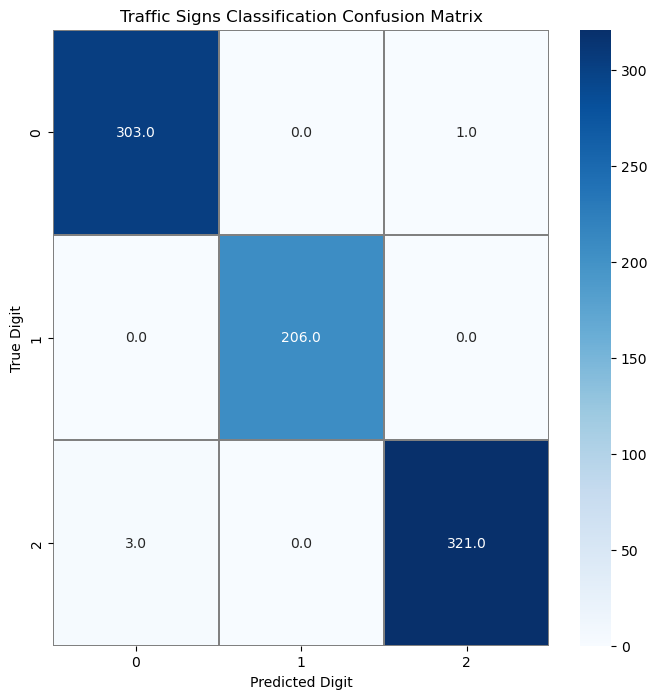

In [36]:
# Get predicted class values from fitted model
y_pred = model.predict(X_test_cnn)

# Get class distributions for predicted and true class values
y_pred_classes =  np.argmax(y_pred, axis=1)
y_true =          np.argmax(y_test_cnn, axis=1)

# Create confusion matrix object from class distributions
cmat = confusion_matrix(y_true, y_pred_classes)

# Render confusion matrix as heatmap visualization
figure, axis = plt.subplots(figsize=(8, 8))
sns.heatmap(cmat,
            annot=True,
            linewidths=0.01,
            cmap="Blues",
            linecolor="gray",
            fmt=".1f",
            ax=axis)
plt.xlabel("Predicted Digit")
plt.ylabel("True Digit")
plt.title("Traffic Signs Classification Confusion Matrix")
plt.show()

<div style="
    background-color: #faf0e6; 
    border: 2px solid #ccc; 
    padding: 10px; 
    font-family: 'Georgia', serif; 
    font-size: 30px; 
    text-align: left;
    color: #696969;
">
    Section 5: Test Data Images (Model has Never Seen These)
</div>

In [52]:
test_image_data = []
test_labels = []
folders = ['Directional_Signs', 'Speed_Limit', 'Warning_Signs']

# reate a mapping from folder names to numeric labels
label_mapping = {'Directional_Signs': 0, 'Speed_Limit': 1, 'Warning_Signs': 2}

#Loop to go through each class folder
for folder_name in folders:
    folder_path = os.path.join(input_dir_test, folder_name)

    #Check if the folder is an actual directory
    if os.path.isdir(folder_path):
        #Loop through each image in the given class folder
        for image in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image)

            #Read the image in color (height, width, channels)
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)

            #This will only proceed if the image exists
            if img is not None:
                #Resize image to fixed size (32x32x3) for CNN input
                img_resized = cv2.resize(img, (32, 32))

                #Add the resized image and the label to the lists above
                test_image_data.append(img_resized)
                test_labels.append(label_mapping[folder_name])
            else:
                print(f"The image could not be read: {image_path}")

#Convert the lists into numpy arrays for efficiency
test_image_data = np.array(test_image_data)  # This will have shape (num_images, 32, 32, 3)
test_labels = np.array(test_labels)

In [53]:
#scaling image data to 0-1 range for the model.

test_image_data = test_image_data / 255.0  

test_image_data

array([[[[0.39215686, 0.39215686, 0.32941176],
         [0.25490196, 0.26666667, 0.19607843],
         [0.29803922, 0.31764706, 0.24705882],
         ...,
         [0.17254902, 0.18039216, 0.16470588],
         [0.19607843, 0.20392157, 0.19215686],
         [0.2627451 , 0.2627451 , 0.25098039]],

        [[0.24313725, 0.24705882, 0.18823529],
         [0.29019608, 0.30588235, 0.23137255],
         [0.17647059, 0.20392157, 0.13333333],
         ...,
         [0.29411765, 0.33333333, 0.30588235],
         [0.32941176, 0.36078431, 0.3372549 ],
         [0.3254902 , 0.34509804, 0.32156863]],

        [[0.68235294, 0.68235294, 0.61960784],
         [0.48627451, 0.49803922, 0.42745098],
         [0.41568627, 0.43921569, 0.36470588],
         ...,
         [0.41960784, 0.49019608, 0.45490196],
         [0.29019608, 0.34901961, 0.31372549],
         [0.31764706, 0.36078431, 0.32941176]],

        ...,

        [[0.41960784, 0.38431373, 0.34117647],
         [0.34117647, 0.32156863, 0.2627451 ]

In [54]:
#one hot encode the test labels so model understands

test_labels_one_hot = to_categorical(test_labels)

In [58]:
evaluation = model.evaluate(test_image_data, test_labels_one_hot, batch_size=batch_size)

# Print the results
print(f"Test loss: {evaluation[0]}")
print(f"Test accuracy: {evaluation[1]}")

63/63 [==============================] - 13s 207ms/step - loss: 0.2576 - accuracy: 0.9308
Test loss: 0.2575570344924927
Test accuracy: 0.9307923913002014


63/63 [==============================] - 1s 8ms/step


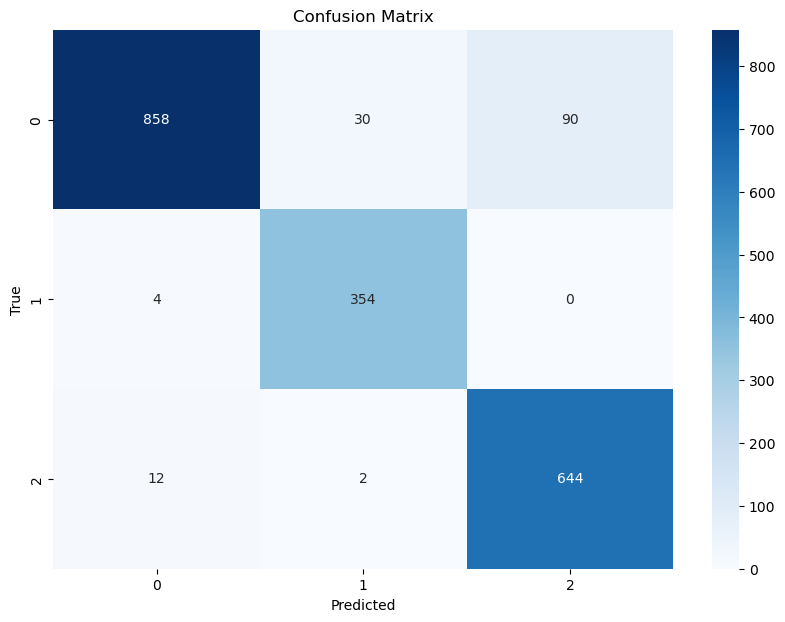

In [56]:
# Step 1: Predict on Test Set
predictions = model.predict(test_image_data)

# Step 2: Convert Predictions to Class Labels
# If your model outputs probabilities, use argmax to get the class label
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_labels  # Assuming test_labels are already in integer format

# Step 3: Compute Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Step 4: Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<div style="
    background-color: #faf0e6; 
    border: 2px solid #ccc; 
    padding: 10px; 
    font-family: 'Georgia', serif; 
    font-size: 30px; 
    text-align: left;
    color: #696969;
">
    Section 6: Analysis & Conclusion
</div>

<div style="background-color: #faf0e6; border: 2px solid #ccc; padding: 9px; width: 100%;">
    <h3 style="color: #696969; margin: 8px 0; text-decoration: underline; font-size: 26px;"><b>Analysis</b></h3>
    <p style="color: black;">The image data that I worked with required some extensive preprocessing. Going back to the very beginning where I performed the EDA on my image data, it was revealed that there were 57 classes, with a very heavy class imbalance. Also, it appeared the images height and width dimensions were fairly equal, in the sense the the majority of the pictures in the dataset were around 140x125 pixels. I also looked into the intensities of the RGB channels of all images, which revealed that red had the highest intensity of all the images. The aspect ratios were almost normally distributed among the 4170 images total used for training. </p>
    <p style="color: black;">When I started this extensive machine learning notebook, I first started using every class. I deployed a shotgun approach after preprocessing my image data. I looped through my images, resized them to a fixed size of 32x32, and then flattened them into a 1D array for a classic machine learning model to learn. Once this step was done and in an array, I converted the array into a pandas dataframe, where I further normalized the data by dividing the pixel range by 255 to get the pixel data into a range of 0 - 1, which would be more manageable for a machine learning model. I did train test splits, and began a functionalized shot gun approach on machine learning classifier models. The result I first achieved was not good at all. I was getting 0 accuracy among 57 classes. It also appeared there many have been an error with one of my for loops which I later rectified, but I was not getting much success on classic machine learning. However, I did not stop there. I went back and recategorized all of my classes, so instead of having 57 classes, I had 3 classes total, for speed limit signs, for directional signs, and for warning signs.</p>
    <p style="color: black;">I had to create new directories in my project path, which required some research and trial and error. After successfully writing a code block to reorganize my images into the new classification, I reapplied the same preprocessing and normalization to my images, this time with adjusted classes. After doing this and running my shot gun approach, I received incredible accuracy right off the bat with my test models, as high as 96 percent! I also employed the Histogram of Oriented Gradients method to extract some heuristics on the images for the classic ML approach. This was interesting and did prove some models to train even better than the classic ML approach which was interesting to see. I was interested in employing a CNN so I moved on to do that.</p>
    <p style="color: black;">I had to preprocess my data again as a CNN takes image data as 2D, instead of 1D which classic machine models do. I essentially applied the same preprocessing as before, resizing images to 32x32, appending them to a new list with the classifier, one hot encoding the classifiers, and normalizing the pixel values again by dividing the images by 255, to get the pixels in a range of 0 - 1. I then created my CNN neural network architecture. I trained the model over 40 epochs, and ended with an accuracy of 99.13%. This was really great! Next, I also had to preprocess some test images, which the model has never seen before. The test image directory was very messy. It was not organized, and the class identification was baked in to the naming convention of the images. So for example, an image was "000_001_j", where 000 represented the class, going from 000 to 057. I created code to look at the first 3 digits of the name string, convert it to an integer, look at a mapping dictionary, and move the image to the target folder based on conditions. </p>
    <p style="color: black;">Once I was ready to throw the testing images at the model, I did the same thing again - preprocessed the images in the same old fashion, and made the batch size the same as the batch size in which the CNN network trained on. As a result, the model scored an accuracy of 93.08 percent! The model is pretty good at identifying traffic signs.</p>
    <p style="color: black;">I think some ways to improve the accuracy would be to further train the model over more epochs, on even more images. Another thing that can be done for further accuracy on test data, would be more samples on class "1", as this had the fewest images, but not by much. </p>
    <p style="color: black;">Overall, this project was very fun and it is ready to be deployed for identifying images!</p>
</div>

<u>**Resources / References**</u>

https://www.analyticsvidhya.com/blog/2022/01/image-classification-using-machine-learning/

https://neptune.ai/blog/data-exploration-for-image-segmentation-and-object-detection

https://jacobheyman702.medium.com/examples-of-eda-for-image-analysis-4d7770924fb5

https://github.com/henrhoi/image-classification/blob/master/feature_extraction_and_exploratory_data_analysis.ipynb

https://www.kaggle.com/code/tarunpaparaju/plant-pathology-2020-eda-models/notebook

https://www.kaggle.com/code/nickyazdani/object-detection-from-scratch-using-tensorflow

https://www.kaggle.com/code/boulahchichenadir/cnn-classification